In [1]:
import os
import ast
import sys
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util

### Consistency - Standard deviation of precision of the CQ generation task

In [2]:
def read_and_clean_txt(file_path):
    # Read the file
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Parse the lines to create a list of lists
    data = [ast.literal_eval(line.strip()) for line in lines]
    
    # Define column names
    column_names = ['Precision4genCQ', 'Recall4genCQ', 'Precision4expertCQ', 'Recall4expertCQ']

    # Convert the list of lists to a DataFrame
    df = pd.DataFrame(data, columns=column_names)
    
    return df

def get_std_temp(foler_path):
    temp = [0.5, 0.75, 1.0, 1.25, 1.5]
    rag_file_count = [0,1,2,3,4,5,10]
    std_set = [] 
    for i_temp in temp:
        std_count = []
        for i_count in rag_file_count:
            file = f'{foler_path}/metric_results/rag-file-count-{i_count}-gpt-4o-temp-{i_temp}.txt'
            df = read_and_clean_txt(file)
            df_P = df['Precision4genCQ'] 
            # get standard deviation of 10 iteration for each temperature and each n_paper
            std = df_P.std()  
            std_count.append(std)
        # print(f'Standard deviation for temperature({i_temp}):\n{std_count}')
        # get average standard deviation for each count
        std_count = sum(std_count)/len(std_count)
        # print(f'Average std for each n_paper at ({i_temp}):\n{std_count}')
        # get average std for each temperature
        std_set.append(std_count)
    return std_set

def plotting_std(metric_hci, metric_re, metric_name):
    x_labels = ['0.5', '0.75', '1.0', '1.25', '1.5']
    x = range(len(x_labels))
    plt.plot(x, metric_hci, label='HCI')
    plt.plot(x, metric_re, label='RE')
    # plt.title(metric_name)
    plt.xlabel('Temperature')
    plt.ylabel('Standard deviation')
    plt.xticks(x, x_labels)
    plt.legend()
    plt.savefig(f'plots/{metric_name}_temperatue.png', dpi=300, bbox_inches='tight')
    plt.show()

# std_p_hci = get_std_temp('hci')
# std_p_re = get_std_temp('re1')
# plotting_std(std_p_hci, std_p_re, 'Standard deviation of Precision for genCQ')

### Consistency - standard deviation of cosine similarity of GPT output text with different temperature

In [3]:
def read_data(file_path):
    with open(file=file_path, mode='r') as f:
        data = f.read()
        return data
    

def get_embeddings(model, sentences):
    embeddings = model.encode(sentences, convert_to_tensor=True)
    return embeddings


def get_similarity(embeddings1, embeddings2):
    similarity = util.pytorch_cos_sim(embeddings1, embeddings2)
    return similarity


def calculate_std(cosine_similarity_tensor):
    """
    Calculate the standard deviation of non-diagonal elements in a tensor.
    
    Parameters:
    cosine_similarity_tensor(np.ndarray): Input tensor with cosine similarity scores.
    
    Returns:
    float: Standard deviation of the non-diagonal elements.
    """
    cos = np.array(cosine_similarity_tensor)
    
    # Remove diagonal values
    non_diagonal_values = cos[~np.eye(cos.shape[0], dtype=bool)]
    
    # Calculate the standard deviation
    std_dev = np.std(non_diagonal_values)
    
    return std_dev

def get_all_std(domain):
    model = SentenceTransformer("all-MiniLM-L6-v2")
    temp = [0.5, 0.75, 1.0, 1.25, 1.5]
    n_paper = [0, 1, 2, 3, 4, 5, 10]
    iteration = [i for i in range(0, 10)]
    std_dev_dict = {}
    for n in n_paper:
        std_dev = []
        for i in temp:
            text_ls = []
            for j in iteration:
                text = read_data(f'{domain}/gpt-output/rag-file-count-{n}/gpt-4o-temp-{i}-iteration-{j}.txt')
                text_ls.append(text)
            embeddings = get_embeddings(model, text_ls)
            cos = get_similarity(embeddings, embeddings)
            std_dev.append(calculate_std(cos))
        std_dev_dict[f'n_paper:{n}'] = std_dev 
    return std_dev_dict

def get_std_set_for_plotting(std_domain):
    temp = ['0.5', '0.75', '1.0', '1.25', '1.5']
    avg_std_set = []
    for idx in range(len(temp)):
        std_temp = []
        for k,v in std_domain.items():
            std_temp.append(v[idx])
        avg = sum(std_temp)/len(std_temp)
        avg_std_set.append(avg)
    return avg_std_set

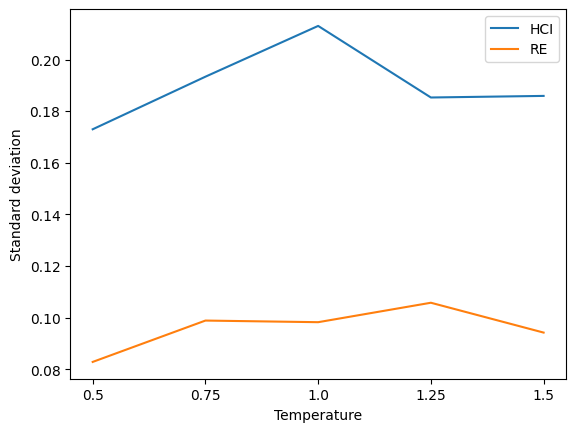

In [4]:
std_p_hci = get_std_temp('hci')
std_p_re = get_std_temp('re')
std_p_re1 = get_std_temp('re1')
plotting_std(std_p_hci, std_p_re, 'Standard deviation of Precision for genCQ')

In [5]:
std_re1 = get_all_std('re1')
std_re = get_all_std('re')
std_hci = get_all_std('hci')
avg_std_cos_hci = get_std_set_for_plotting(std_hci)
avg_std_cos_re = get_std_set_for_plotting(std_re)
avg_std_cos_re1 = get_std_set_for_plotting(std_re1)

/usr/local/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


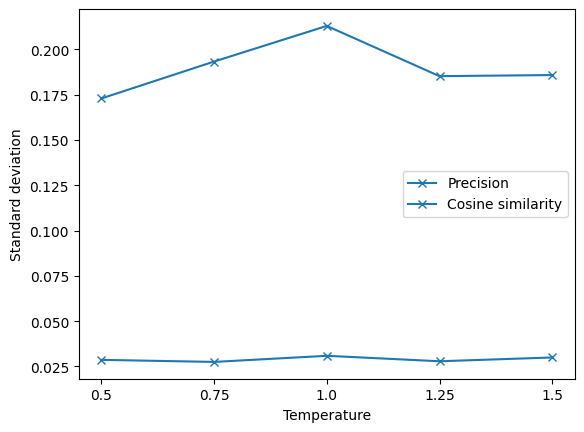

In [6]:
x_labels = ['0.5', '0.75', '1.0', '1.25', '1.5']
x = range(len(x_labels))
plt.plot(x, std_p_hci, marker='x',color = '#1f77b4', label='Precision')
plt.plot(x, avg_std_cos_hci, marker='x', color = '#1f77b4', label='Cosine similarity')
plt.xlabel('Temperature')
plt.ylabel('Standard deviation')
plt.xticks(x, x_labels)
plt.legend()
plt.savefig(f'plots/std_hci.png', dpi=300, bbox_inches='tight')
plt.show()

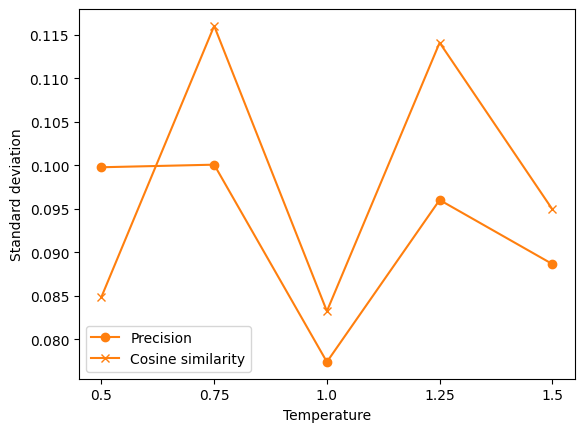

In [7]:
x_labels = ['0.5', '0.75', '1.0', '1.25', '1.5']
x = range(len(x_labels))
plt.plot(x, std_p_re1, marker='o', color='#ff7f0e', label='Precision')
plt.plot(x, avg_std_cos_re1, marker='x', color='#ff7f0e', label='Cosine similarity')
plt.xlabel('Temperature')
plt.ylabel('Standard deviation')
plt.xticks(x, x_labels)
plt.legend()
plt.savefig(f'plots/std_re.png', dpi=300, bbox_inches='tight')
plt.show()

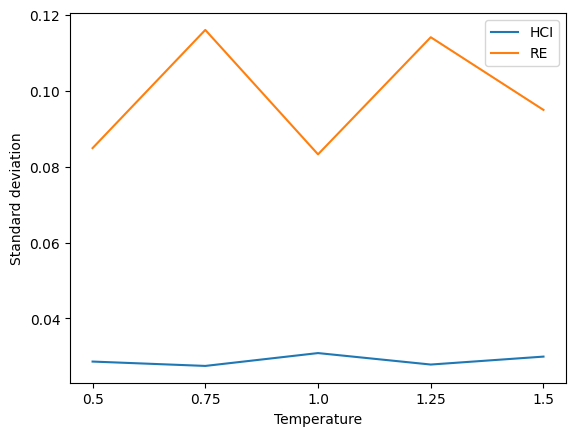

In [8]:
x_labels = ['0.5', '0.75', '1.0', '1.25', '1.5']
x = range(len(x_labels))
plt.plot(x, avg_std_cos_hci, label='HCI')
# plt.plot(x, avg_std_set_re, marker='x', label='RE')
plt.plot(x, avg_std_cos_re1, label='RE')
# plt.title('Standard deviation of cosine similarity of the generated output text')
plt.xlabel('Temperature')
plt.ylabel('Standard deviation')
plt.xticks(x, x_labels)
plt.legend()
plt.savefig(f'plots/avg_std_temp.png', dpi=300, bbox_inches='tight')
plt.show()

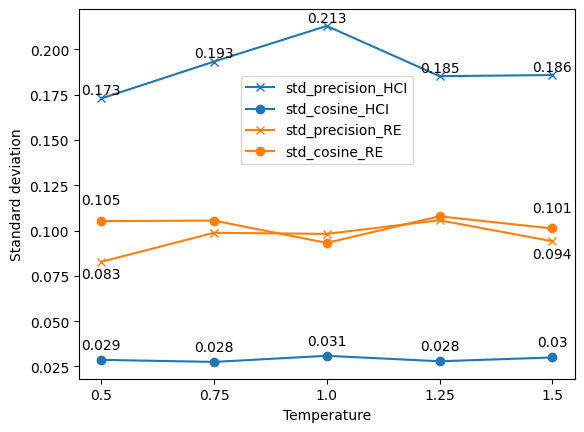

In [9]:
x_labels = ['0.5', '0.75', '1.0', '1.25', '1.5']
x = range(len(x_labels))

plt.plot(x, std_p_hci, color = '#1f77b4', marker='x', label='std_precision_HCI')
plt.plot(x, avg_std_cos_hci, color = '#1f77b4', marker='o', label='std_cosine_HCI')
plt.plot(x, std_p_re, color = '#ff7f0e', marker='x', label='std_precision_RE')
plt.plot(x, avg_std_cos_re, color = '#ff7f0e', marker='o', label='std_cosine_RE')

for i in range(len(x_labels)):
    plt.annotate(round(std_p_hci[i], 3), (x[i], std_p_hci[i]), textcoords="offset points", xytext=(0,3), ha='center')

for i in [0,4]:
    plt.annotate(round(std_p_re[i], 3), (x[i], std_p_re[i]), textcoords="offset points", xytext=(0,-12), ha='center')

for i in range(len(x_labels)):
    plt.annotate(round(avg_std_cos_hci[i], 3), (x[i], avg_std_cos_hci[i]), textcoords="offset points", xytext=(0,8), ha='center')

for i in [0,4]:
    plt.annotate(round(avg_std_cos_re[i], 3), (x[i], avg_std_cos_re[i]), textcoords="offset points", xytext=(0,12), ha='center')

# plt.title('Standard deviation of cosine similarity of the generated output text')
plt.xlabel('Temperature')
plt.ylabel('Standard deviation')
plt.xticks(x, x_labels)
plt.legend(loc='center', bbox_to_anchor=(0.5, 0.7))
plt.savefig(f'plots/avg_std_temp.png', dpi=300, bbox_inches='tight')
plt.show()

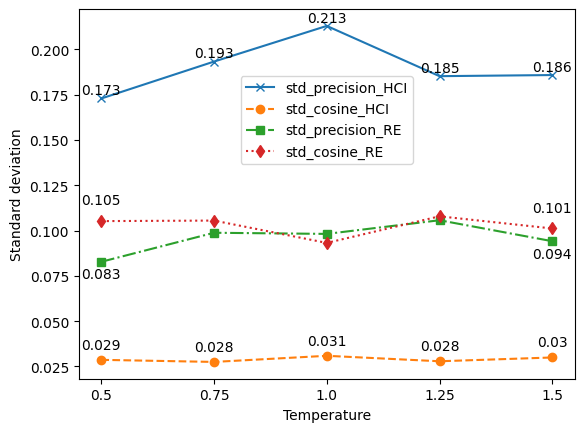

In [12]:
x_labels = ['0.5', '0.75', '1.0', '1.25', '1.5']
x = range(len(x_labels))

# plt.plot(x, std_p_hci, linestyle='-', marker='x', label='std_precision_HCI')
# plt.plot(x, avg_std_cos_hci, linestyle='-', marker='o', label='std_cosine_HCI')
# plt.plot(x, std_p_re, linestyle=':', marker='x', label='std_precision_RE')
# plt.plot(x, avg_std_cos_re, linestyle=':', marker='o', label='std_cosine_RE')
plt.plot(x, std_p_hci, linestyle='-', marker='x', label='std_precision_HCI')
plt.plot(x, avg_std_cos_hci, linestyle='--', marker='o', label='std_cosine_HCI')
plt.plot(x, std_p_re, linestyle='-.', marker='s', label='std_precision_RE')
plt.plot(x, avg_std_cos_re, linestyle=':', marker='d', label='std_cosine_RE')

for i in range(len(x_labels)):
    plt.annotate(round(std_p_hci[i], 3), (x[i], std_p_hci[i]), textcoords="offset points", xytext=(0,3), ha='center')

for i in [0,4]:
    plt.annotate(round(std_p_re[i], 3), (x[i], std_p_re[i]), textcoords="offset points", xytext=(0,-12), ha='center')

for i in range(len(x_labels)):
    plt.annotate(round(avg_std_cos_hci[i], 3), (x[i], avg_std_cos_hci[i]), textcoords="offset points", xytext=(0,8), ha='center')

for i in [0,4]:
    plt.annotate(round(avg_std_cos_re[i], 3), (x[i], avg_std_cos_re[i]), textcoords="offset points", xytext=(0,12), ha='center')

# plt.title('Standard deviation of cosine similarity of the generated output text')
plt.xlabel('Temperature')
plt.ylabel('Standard deviation')
plt.xticks(x, x_labels)
plt.legend(loc='center', bbox_to_anchor=(0.5, 0.7))
plt.savefig(f'plots/avg_std_temp.png', dpi=300, bbox_inches='tight')
plt.show()